## Giới thiệu bài toán phân loại văn bản
Để giải quyết một bài toán phân loại văn bản, ta thực hiện 4 bước:

*  Chuẩn bị dữ liệu (Dataset Preparation)
*  Xử lý thuộc tính của dữ liệu (Feature Engineering)
*  Xây dựng mô hình (Build Model)
*  Tinh chỉnh mô hình và cải thiện hiệu năng (Improve Performance)

## Chuẩn bị dữ liệu

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import pandas as pd
reviews_data = pd.read_csv('/content/gdrive/MyDrive/NLP/reviews.csv', encoding = 'UTF-8')
reviews_data.head()

,Order_ID,Comment_ID,User_ID,Comment,Rating_Star,Ratings__Status,Author_Username
0,1.544590e+14,13362838929,109914495,Công dụng:tẩy tế bào chết\nPhù hợp với loại da...,5,2,vuhao1410
1,1.544920e+14,13338100481,456589896,Công dụng:tẩy tế bào chết\nMùi hương:cafe\nPhù...,5,2,haxinhdep_ne
2,1.182200e+14,9725774401,138599161,"Công dụng:tay da chet\nMùi hương:cà phê, ngọt\...",5,2,t*****g
3,1.369200e+14,11442520575,477471542,Công dụng:tẩy tế bào chết\nPhù hợp với loại da...,5,2,b4j2olz84f
4,1.589540e+14,14050960335,33000391,Phù hợp với loại da:mọi loại da\nCông dụng:tẩy...,5,2,t*****8


In [ ]:
reviews_data.columns = ['order_id', 'comment_id', 'user_id', 'comment', 'rating_star', 'ratings__status', 'author_username']
reviews_data.drop(columns=['order_id', 'user_id', 'ratings__status', 'author_username'], inplace=True)

In [ ]:
reviews_data.head()

,comment_id,comment,rating_star
0,13362838929,Công dụng:tẩy tế bào chết\nPhù hợp với loại da...,5
1,13338100481,Công dụng:tẩy tế bào chết\nMùi hương:cafe\nPhù...,5
2,9725774401,"Công dụng:tay da chet\nMùi hương:cà phê, ngọt\...",5
3,11442520575,Công dụng:tẩy tế bào chết\nPhù hợp với loại da...,5
4,14050960335,Phù hợp với loại da:mọi loại da\nCông dụng:tẩy...,5


In [ ]:
# Lọc phần comment trong data gốc

def clean_comment(x):
    return x.split('\\n')[-1]

In [ ]:
reviews_data['comment_only'] = reviews_data['comment'].apply(clean_comment)

In [ ]:
reviews_data.head()

,comment_id,comment,rating_star,comment_only
0,13362838929,Công dụng:tẩy tế bào chết\nPhù hợp với loại da...,5,"Túi được khá nhiều, đóng gói cẩn thận, không b..."
1,13338100481,Công dụng:tẩy tế bào chết\nMùi hương:cafe\nPhù...,5,Sản phẩm chất lượng mk sử dụng khá lâu r nay t...
2,9725774401,"Công dụng:tay da chet\nMùi hương:cà phê, ngọt\...",5,"Mùi thơm nhẹ dễ chịu, ngọt ngọt ý. Đóng gói đẹ..."
3,11442520575,Công dụng:tẩy tế bào chết\nPhù hợp với loại da...,5,Mình chưa trải nghiệm sản phẩm nên k biết . Nh...
4,14050960335,Phù hợp với loại da:mọi loại da\nCông dụng:tẩy...,5,Shop soạn hàng rất nhanh. Đóng gói kỹ.


In [ ]:
reviews_data.drop(columns=['comment'], inplace=True)
reviews_data.rename(columns={"comment_only": "comment"}, inplace=True)

In [ ]:
reviews_data.head(2)

,comment_id,rating_star,comment
0,13362838929,5,"Túi được khá nhiều, đóng gói cẩn thận, không b..."
1,13338100481,5,Sản phẩm chất lượng mk sử dụng khá lâu r nay t...


#### Chuẩn bị các hàm để sử dụng trong việc xử lý dữ liệu và các bước sau đó:
##### Chuyển câu văn về kiểu gõ telex khi không bật Unikey     
(Ví dụ: thủy = thuyr, tượng = tuwowngj)

In [ ]:
bang_nguyen_am = [['a', 'à', 'á', 'ả', 'ã', 'ạ', 'a'],
                  ['ă', 'ằ', 'ắ', 'ẳ', 'ẵ', 'ặ', 'aw'],
                  ['â', 'ầ', 'ấ', 'ẩ', 'ẫ', 'ậ', 'aa'],
                  ['e', 'è', 'é', 'ẻ', 'ẽ', 'ẹ', 'e'],
                  ['ê', 'ề', 'ế', 'ể', 'ễ', 'ệ', 'ee'],
                  ['i', 'ì', 'í', 'ỉ', 'ĩ', 'ị', 'i'],
                  ['o', 'ò', 'ó', 'ỏ', 'õ', 'ọ', 'o'],
                  ['ô', 'ồ', 'ố', 'ổ', 'ỗ', 'ộ', 'oo'],
                  ['ơ', 'ờ', 'ớ', 'ở', 'ỡ', 'ợ', 'ow'],
                  ['u', 'ù', 'ú', 'ủ', 'ũ', 'ụ', 'u'],
                  ['ư', 'ừ', 'ứ', 'ử', 'ữ', 'ự', 'uw'],
                  ['y', 'ỳ', 'ý', 'ỷ', 'ỹ', 'ỵ', 'y']]
bang_ky_tu_dau = ['', 'f', 's', 'r', 'x', 'j']

nguyen_am_to_ids = {}

for i in range(len(bang_nguyen_am)):
    for j in range(len(bang_nguyen_am[i]) - 1):
        nguyen_am_to_ids[bang_nguyen_am[i][j]] = (i, j)


def vn_word_to_telex_type(word):
    dau_cau = 0
    new_word = ''
    for char in word:
        x, y = nguyen_am_to_ids.get(char, (-1, -1))
        if x == -1:
            new_word += char
            continue
        if y != 0:
            dau_cau = y
        new_word += bang_nguyen_am[x][-1]
    new_word += bang_ky_tu_dau[dau_cau]
    return new_word


def vn_sentence_to_telex_type(sentence):
    """
    Chuyển câu tiếng việt có dấu về kiểu gõ telex.
    :param sentence:
    :return:
    """
    words = sentence.split()
    for index, word in enumerate(words):
        words[index] = vn_word_to_telex_type(word)
    return ' '.join(words)

##### Chuyển câu văn về cách gõ dấu kiểu cũ: dùng òa úy thay oà uý

In [ ]:
def chuan_hoa_dau_tu_tieng_viet(word):
    if not is_valid_vietnam_word(word):
        return word

    chars = list(word)
    dau_cau = 0
    nguyen_am_index = []
    qu_or_gi = False
    for index, char in enumerate(chars):
        x, y = nguyen_am_to_ids.get(char, (-1, -1))
        if x == -1:
            continue
        elif x == 9:  # check qu
            if index != 0 and chars[index - 1] == 'q':
                chars[index] = 'u'
                qu_or_gi = True
        elif x == 5:  # check gi
            if index != 0 and chars[index - 1] == 'g':
                chars[index] = 'i'
                qu_or_gi = True
        if y != 0:
            dau_cau = y
            chars[index] = bang_nguyen_am[x][0]
        if not qu_or_gi or index != 1:
            nguyen_am_index.append(index)
    if len(nguyen_am_index) < 2:
        if qu_or_gi:
            if len(chars) == 2:
                x, y = nguyen_am_to_ids.get(chars[1])
                chars[1] = bang_nguyen_am[x][dau_cau]
            else:
                x, y = nguyen_am_to_ids.get(chars[2], (-1, -1))
                if x != -1:
                    chars[2] = bang_nguyen_am[x][dau_cau]
                else:
                    chars[1] = bang_nguyen_am[5][dau_cau] if chars[1] == 'i' else bang_nguyen_am[9][dau_cau]
            return ''.join(chars)
        return word

    for index in nguyen_am_index:
        x, y = nguyen_am_to_ids[chars[index]]
        if x == 4 or x == 8:  # ê, ơ
            chars[index] = bang_nguyen_am[x][dau_cau]
            # for index2 in nguyen_am_index:
            #     if index2 != index:
            #         x, y = nguyen_am_to_ids[chars[index]]
            #         chars[index2] = bang_nguyen_am[x][0]
            return ''.join(chars)

    if len(nguyen_am_index) == 2:
        if nguyen_am_index[-1] == len(chars) - 1:
            x, y = nguyen_am_to_ids[chars[nguyen_am_index[0]]]
            chars[nguyen_am_index[0]] = bang_nguyen_am[x][dau_cau]
            # x, y = nguyen_am_to_ids[chars[nguyen_am_index[1]]]
            # chars[nguyen_am_index[1]] = bang_nguyen_am[x][0]
        else:
            # x, y = nguyen_am_to_ids[chars[nguyen_am_index[0]]]
            # chars[nguyen_am_index[0]] = bang_nguyen_am[x][0]
            x, y = nguyen_am_to_ids[chars[nguyen_am_index[1]]]
            chars[nguyen_am_index[1]] = bang_nguyen_am[x][dau_cau]
    else:
        # x, y = nguyen_am_to_ids[chars[nguyen_am_index[0]]]
        # chars[nguyen_am_index[0]] = bang_nguyen_am[x][0]
        x, y = nguyen_am_to_ids[chars[nguyen_am_index[1]]]
        chars[nguyen_am_index[1]] = bang_nguyen_am[x][dau_cau]
        # x, y = nguyen_am_to_ids[chars[nguyen_am_index[2]]]
        # chars[nguyen_am_index[2]] = bang_nguyen_am[x][0]
    return ''.join(chars)


def is_valid_vietnam_word(word):
    chars = list(word)
    nguyen_am_index = -1
    for index, char in enumerate(chars):
        x, y = nguyen_am_to_ids.get(char, (-1, -1))
        if x != -1:
            if nguyen_am_index == -1:
                nguyen_am_index = index
            else:
                if index - nguyen_am_index != 1:
                    return False
                nguyen_am_index = index
    return True


def chuan_hoa_dau_cau_tieng_viet(sentence):
    """
        Chuyển câu tiếng việt về chuẩn gõ dấu kiểu cũ.
        :param sentence:
        :return:
        """
    sentence = sentence.lower()
    words = sentence.split()
    for index, word in enumerate(words):
        words[index] = chuan_hoa_dau_tu_tieng_viet(word)
    return ' '.join(words)


##### Hàm xử lý chung

In [ ]:
%pip install underthesea

In [ ]:
import re
from underthesea import word_tokenize

def text_preprocess(document):
    document = convertwindown1525toutf8(document)
    document = chuan_hoa_dau_cau_tieng_viet(document)
    # TOKENIZE
    document = word_tokenize(document,format="text")
    # REMOVE unnecessary char
    document = document.strip(".?,/:#@$%^&*()!")
    document = re.sub(r'\s+',' ', document).strip()
    return document

# utils
def isNaN(string):
    return string != string

uniChars = "àáảãạâầấẩẫậăằắẳẵặèéẻẽẹêềếểễệđìíỉĩịòóỏõọôồốổỗộơờớởỡợùúủũụưừứửữựỳýỷỹỵÀÁẢÃẠÂẦẤẨẪẬĂẰẮẲẴẶÈÉẺẼẸÊỀẾỂỄỆĐÌÍỈĨỊÒÓỎÕỌÔỒỐỔỖỘƠỜỚỞỠỢÙÚỦŨỤƯỪỨỬỮỰỲÝỶỸỴÂĂĐÔƠƯ"
unsignChars = "aaaaaaaaaaaaaaaaaeeeeeeeeeeediiiiiooooooooooooooooouuuuuuuuuuuyyyyyAAAAAAAAAAAAAAAAAEEEEEEEEEEEDIIIOOOOOOOOOOOOOOOOOOOUUUUUUUUUUUYYYYYAADOOU"


def loaddicchar():
    dic = {}
    char1252 = 'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ'.split(
        '|')
    charutf8 = "à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ".split(
        '|')
    for i in range(len(char1252)):
        dic[char1252[i]] = charutf8[i]
    return dic

dicchar = loaddicchar()

def convertwindown1525toutf8(txt):
    return re.sub(
        r'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ',
        lambda x: dicchar[x.group()], txt)


### Thực hiện xử lý và chuẩn bị dữ liệu
#### Chuẩn hóa dấu câu

In [ ]:
commentNormalized = []

for comment in reviews_data["comment"]:
    try:
        commentNormalized.append(text_preprocess(comment))
    except:
        commentNormalized.append('')

commentNormalized[0:2]

['túi được khá nhiều , đóng_gói cẩn_thận , không bị móp meó , còn nguyên_seal , mùi cà_phê siêu_thơm , mọi lần dùng lọ , lần này mua túi mà thấy ổn_áp lắm',
 'sản_phẩm chất_lượng mk sử_dụng khá lâu_r nay thấy sale hời quá mua 1 tặng 1 quá xịn có 325 k date mới nha quá xịn ai còn phân_vân cứ mạnh dạng chốt sp làm sạch da thơm_mềm mịn']

#### XỬ lý stop word

In [ ]:
vnStopwords = pd.read_csv("/content/gdrive/MyDrive/NLP/stopwordVI.csv")
stopwords=vnStopwords["stopwords"].tolist()

sentences = [word_tokenize(str(i)) for i in reviews_data["comment"]]

sentencesNoStops = [' '.join([word for word in i if word not in stopwords]) for i in sentences]

commentNoStops = pd.DataFrame({'comment no stops words': sentencesNoStops})
print('comment after removing stopwords')
commentNoStops[0:5]

comment after removing stopwords


,comment no stops words
0,"Túi , đóng gói cẩn thận , móp méo , nguyên sea..."
1,Sản phẩm chất lượng mk lâu r sale hời mua 1 tặ...
2,"Mùi thơm nhẹ dễ chịu , ngọt ý . Đóng gói đẹp m..."
3,Mình trải nghiệm sản phẩm k . Nhìn chung giá r...
4,Shop soạn hàng . Đóng gói kỹ .


In [ ]:
reviews_data.head()

,comment_id,rating_star,comment
0,13362838929,5,"Túi được khá nhiều, đóng gói cẩn thận, không b..."
1,13338100481,5,Sản phẩm chất lượng mk sử dụng khá lâu r nay t...
2,9725774401,5,"Mùi thơm nhẹ dễ chịu, ngọt ngọt ý. Đóng gói đẹ..."
3,11442520575,5,Mình chưa trải nghiệm sản phẩm nên k biết . Nh...
4,14050960335,5,Shop soạn hàng rất nhanh. Đóng gói kỹ.


#### Xử lý sentiment cho từng comment tự động
Có thể thấy việc xử lý dữ liệu bằng cách loại bỏ stopword không hiệu quả lắm đối với tiếng việt nên chúng ta không sử dụng cách loại bỏ stopword. Trong file này chúng ta vẫn sẽ để một cột "comment normalize no stopword" để so sánh

In [ ]:
from underthesea import sentiment
sentiment = [sentiment(str(i)) for i in commentNormalized]

d = {
    "comment_id": reviews_data["comment_id"],
    "rating_star": reviews_data["rating_star"],
    "comment":reviews_data["comment"], # comment: cột gốc
    "comment_normalized":commentNormalized, # comment_normalized: commentNormalized là comment gốc apply "text_preprocess"
    "comment_no_stopword": sentencesNoStops, # comment_no_stopword: word_tokenize comment gốc, sau đó loại bỏ stopwords
    "sentiment": sentiment # sentiment: dựa trên commentNormalized
    }
df = pd.DataFrame(d)

In [ ]:
df.head(2)

,comment_id,rating_star,comment,comment_normalized,comment_no_stopword,sentiment
0,13362838929,5,"Túi được khá nhiều, đóng gói cẩn thận, không b...","túi được khá nhiều , đóng_gói cẩn_thận , không...","Túi , đóng gói cẩn thận , móp méo , nguyên sea...",negative
1,13338100481,5,Sản phẩm chất lượng mk sử dụng khá lâu r nay t...,sản_phẩm chất_lượng mk sử_dụng khá lâu_r nay t...,Sản phẩm chất lượng mk lâu r sale hời mua 1 tặ...,positive


#### Load dữ liệu

In [ ]:
%pip install pyvi
%pip install sklearn
%pip install gensim

  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
from pyvi import ViTokenizer, ViPosTagger # thư viện NLP tiếng Việt
from tqdm import tqdm
import numpy as np
import gensim # thư viện NLP

Chúng ta sẽ dùng thư viện underthesea để gắn nhãn tự động

positive    2108
negative    1003
Name: sentiment, dtype: int64


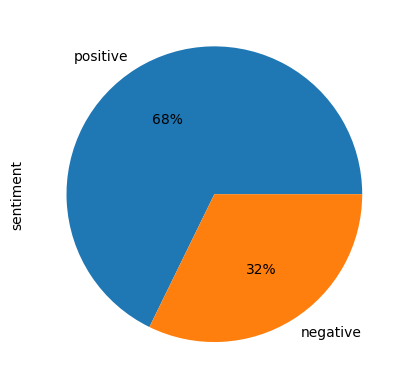

In [ ]:
import matplotlib.pyplot as plt
countClass = pd.value_counts(df["sentiment"], sort=True)
print(countClass)
countClass.plot(kind="pie", autopct='%1.0f%%')
plt.show()

Dựng wordcloud

In [ ]:
%pip install WordCloud
%pip install matplotlib

In [ ]:
df.head(2)

,comment_id,rating_star,comment,comment_normalized,comment_no_stopword,sentiment
0,13362838929,5,"Túi được khá nhiều, đóng gói cẩn thận, không b...","túi được khá nhiều , đóng_gói cẩn_thận , không...","Túi , đóng gói cẩn thận , móp méo , nguyên sea...",negative
1,13338100481,5,Sản phẩm chất lượng mk sử dụng khá lâu r nay t...,sản_phẩm chất_lượng mk sử_dụng khá lâu_r nay t...,Sản phẩm chất lượng mk lâu r sale hời mua 1 tặ...,positive


Positive words


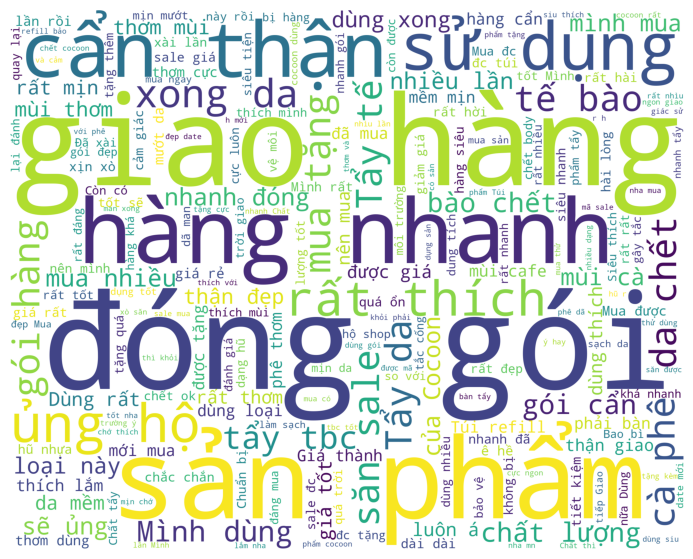

Negative words


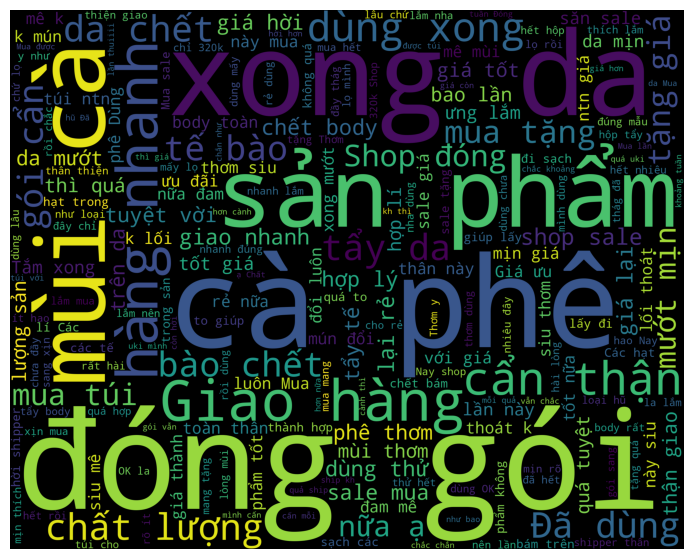

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud
import matplotlib.pyplot as plt

d = df[['comment','sentiment']]


train_pos = d[d['sentiment'] == 'positive']
train_pos = train_pos['comment']

train_neg = d[d['sentiment'] == 'negative']
train_neg = train_neg['comment']


vnStopwords = pd.read_csv("/content/gdrive/MyDrive/NLP/stopwordVI.csv")
stopwords=vnStopwords["stopwords"].tolist()

def wordcloud_draw(d, color = 'black'):
    words = ' '.join(d)
    cleaned_word = " ".join([word for word in words.split()])
    wordcloud = WordCloud(stopwords=vnStopwords, background_color=color, width=2500, height=2000).generate(cleaned_word)

    plt.figure(1,figsize=(10, 7))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

print("Positive words")
wordcloud_draw(train_pos,'white')
print("Negative words")
wordcloud_draw(train_neg)

Tiến hành chia tập dữ liệu ra làm tập train và test:

In [ ]:
df.sample(2)

,comment_id,rating_star,comment,comment_normalized,comment_no_stopword,sentiment
1732,12256276014,5,"Shop giao hàng nhanh, đóng gói cẩn thận. Mua đ...","shop giao hàng nhanh , đóng_gói cẩn_thận . mua...","Shop giao hàng , đóng gói cẩn thận . Mua đợt s...",None
1592,9836776098,5,"Thơm mùi cà phê đặc trưng, hạt massage nhỏ khô...","thơm mùi cà_phê đặc_trưng , hạt massage nhỏ kh...","Thơm mùi cà phê đặc trưng , hạt massage rát mặ...",positive


In [ ]:
df.sentiment.fillna('neutral', inplace=True)

In [ ]:
X = df["comment_normalized"].values
y = df["sentiment"].values

# Chia tập train/test
test_percent = 0.2

#Chia tập dữ liệu ra train và test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_percent, random_state=30)

Để tiện sử dụng cho việc sử dụng lại dữ liệu đã được xử lý, các bạn có thể lưu dữ liệu lại vào file .pkl:

Chúng ta cũng xử lý tương tự với dữ liệu test:

## Feature Engineering

Ở bước này, chúng ta sẽ đưa dữ liệu dạng văn bản đã được xử lý về dạng vector thuộc tính có dạng số học. Có nhiều các khác nhau để đưa dữ liệu văn bản dạng text về dữ liệu dạng số mà chúng ta có thể thực hiện như:

* Count Vectors as features
* TF-IDF Vectors as features
* Word level
* N-Gram level
* Character level
* Word Embeddings as features
* Text / NLP based features
* Topic Models as features

### Count Vectors as features

Khi sử dụng phương pháp này, chúng ta sẽ thu được một ma trận mà trong đó, mỗi hàng sẽ đại diện cho một văn bản, mỗi cột đại diện cho một từ có trong từ điển, và mỗi ô (cell) sẽ chứa tần suất xuất hiện của từ trong văn bản tương ứng. Bằng cách sử dụng thư viện sklearn, chúng ta sẽ làm như sau:

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer


# create a count vectorizer object
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vect.fit(X_train)

# transform the training and validation data using count vectorizer object
X_train_count = count_vect.transform(X_train)
X_test_count = count_vect.transform(X_test)


### Tf-Idf Vectors as Features
Có thể mọi người đã từng nghe đến phương pháp TF-IDF (Term Frequency - Inverse Document Frequency), đây là một phương pháp cực kì phổ biến trong xử lý văn bản. Nó được tính theo công thức dưới đây:

* TF(t) = (Number of times term t appears in a document) / (Total number of terms in the document)
* IDF(t) = log_e(Total number of documents / Number of documents with term t in it)

Chúng ta có thể thực hiện TF-IDF cho các cấp độ khác nhau của văn bản như sau:

#### **a. Word Level TF-IDF** : Thực hiện tính toán dựa trên mỗi thành phần là một từ riêng lẻ.

In [ ]:
# word level - we choose max number of words equal to 30000 except all words (100k+ words)
tfidf_vect = TfidfVectorizer(analyzer='word', max_features=30000)
tfidf_vect.fit(X_train) # learn vocabulary and idf from training set
X_train_tfidf =  tfidf_vect.transform(X_train)
# assume that we don't have test set before
X_test_tfidf =  tfidf_vect.transform(X_test)


#### **b. N-gram Level TF-IDF** : Kết hợp n thành phần (từ) liên tiếp nhau.

Ví dụ: "thủ_tướng đức nhận_lời tham_dự lễ kỷ_niệm". Khi đó, 2-gram cho ta kết quả: {thủ_tướng đức, đức nhận_lời, nhận_lời tham_dự, tham_dự lễ , lễ kỷ_niệm}. Mõi phần từ là cặp 2 từ liên tiếp nhau.

In [ ]:
# ngram level - we choose max number of words equal to 30000 except all words (100k+ words)
tfidf_vect_ngram = TfidfVectorizer(analyzer='word', max_features=30000, ngram_range=(2, 3))
tfidf_vect_ngram.fit(X_train)
X_train_tfidf_ngram =  tfidf_vect_ngram.transform(X_train)
# assume that we don't have test set before
X_test_tfidf_ngram =  tfidf_vect_ngram.transform(X_test)


#### **c. Character Level TF-IDF** : Dựa trên n-gram của ký tự.

In [ ]:
# ngram-char level - we choose max number of words equal to 30000 except all words (100k+ words)
tfidf_vect_ngram_char = TfidfVectorizer(analyzer='char', max_features=30000, ngram_range=(2, 3))
tfidf_vect_ngram_char.fit(X_train)
X_train_tfidf_ngram_char =  tfidf_vect_ngram_char.transform(X_train)
# assume that we don't have test set before
X_test_tfidf_ngram_char =  tfidf_vect_ngram_char.transform(X_test)


Sau khi thực hiện TF-IDF, chúng ta dễ dàng nhận thấy rằng, ma trận mà chúng ta thu được có kích thước rất lớn, và việc xử lý tính toán với ma trận này đòi hỏi thời gian và bộ nhớ khá tốn kém. Giả sử, chúng ta có 100.000 văn bản và bộ từ điển bao gồm 50000 từ, khi đó ma trận mà chúng ta thu được sẽ có kích thước là 100000 * 50000. Giả sử mỗi phần tử được lưu dưới dạng float32 - 4 byte, bộ nhớ mà chúng ta cần sử dụng là:

100000 \times 50000 \times 4 = 20000000000\ byte
100000×50000×4=20000000000 byte

tức là chúng ta tốn tầm 18.63GB bộ nhớ, khó có thể lưu hết vào RAM để thực hiện tính toán. Trong thực tế, với số lượng văn bản khổng lồ và từ điển lên đến hàng trăm nghìn từ, bộ nhớ mà chúng ta sử dụng còn tốn kém hơn rất nhiều. Để xử lý vấn đề này, chúng ta sẽ sử dụng thuật toán SVD (singular value decomposition) nhằm mục đích giảm chiều dữ liệu của ma trận mà chúng ta thu được, mà vẫn giữ nguyên được các thuộc tính của ma trận gốc ban đầu.

#### **Word Level**

In [ ]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=300, random_state=42)
svd.fit(X_train_tfidf)


X_train_tfidf_svd = svd.transform(X_train_tfidf)
X_test_tfidf_svd = svd.transform(X_test_tfidf)


#### **N-gram Level**

In [ ]:
svd_ngram = TruncatedSVD(n_components=300, random_state=42)
svd_ngram.fit(X_train_tfidf_ngram)

X_train_tfidf_ngram_svd = svd_ngram.transform(X_train_tfidf_ngram)
X_test_tfidf_ngram_svd = svd_ngram.transform(X_test_tfidf_ngram)


#### **N-gram Char Level**

In [ ]:
svd_ngram_char = TruncatedSVD(n_components=300, random_state=42)
svd_ngram_char.fit(X_train_tfidf_ngram_char)

X_train_tfidf_ngram_char_svd = svd_ngram_char.transform(X_train_tfidf_ngram_char)
X_test_tfidf_ngram_char_svd = svd_ngram_char.transform(X_test_tfidf_ngram_char)


## Xây dựng mô hình

Trong phần này, chúng ta sẽ xây dựng các mô hình phân loại văn bản sau:

* Naive Bayes Classifier
* Linear Classifier
* Support Vector Machine
* Bagging Models
    * Deep Neural Networks
    * Convolutional Neural Network (CNN)
    * Long Short Term Modelr (LSTM)
    * Gated Recurrent Unit (GRU)
    * Bidirectional RNN
    * Recurrent Convolutional Neural Network (RCNN)
* Doc2Vec model


### Label Encoder

Trước hết, chúng ta cần chuyển nhãn dữ liệu về dạng số phục vụ quá trình huấn luyện. Nhãn của chúng ta đang có dạng văn bản như sau: **['negative', 'neutral', 'positive']** tương ứng với các cấp độ rating của comment. Tuy nhiên do quá trình input thì hiện tại văn bản đang ở dạng string. Để chuyển dạng văn bản về dạng số, chúng ta sử dụng LabelEncoder của thư viện sklearn. Cách thực hiện đơn giản là như sau:

In [ ]:
from sklearn import preprocessing
encoder = preprocessing.LabelEncoder()
y_train_n = encoder.fit_transform(y_train)
y_test_n = encoder.fit_transform(y_test)

encoder.classes_


array(['negative', 'neutral', 'positive'], dtype=object)

Do hạn chế về mặt tính toán, ở đây chúng ta sẽ sử dụng TF-IDF chưa và đã được xử lý bằng SVD, khi đó mỗi vector đại diện cho một văn bản đang là vector 300 chiều.

### Xây dựng mô hình
Để code sử dụng được ngắn gọn, chúng ta sẽ sử dụng chung một hàm huấn luyện và dự đoán cho tất cả các mô hình, việc này làm giảm bớt thời gian viết code của chúng ta rất nhiều, chi tiết như sau:

In [ ]:
%pip install scikit-plot

In [ ]:
import matplotlib.pyplot as plt
import scikitplot as skplt
from sklearn import metrics

def train_model(classifier, X_train, y_train, X_test, y_test, is_neuralnet=False, n_epochs=3):
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

    if is_neuralnet:
        classifier.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=n_epochs, batch_size=512)

        val_predictions = classifier.predict(X_val)
        test_predictions = classifier.predict(X_test)
        val_predictions = val_predictions.argmax(axis=-1)
        test_predictions = test_predictions.argmax(axis=-1)
        skplt.metrics.plot_confusion_matrix(y_val,val_predictions,text_fontsize="medium",cmap='Greens',figsize=(8,8))
        plt.show()
        print("Train accuracy: ", metrics.accuracy_score(val_predictions, y_val))
        print("Test accuracy: ", metrics.accuracy_score(test_predictions, y_test))
    else:
        classifier.fit(X_train, y_train)
        train_predictions = classifier.predict(X_train)
        val_predictions = classifier.predict(X_val)
        test_predictions = classifier.predict(X_test)
        skplt.metrics.plot_confusion_matrix(y_train,train_predictions,text_fontsize="medium",cmap='Greens',figsize=(8,8))
        plt.show()
        print("Train accuracy: ", metrics.accuracy_score(train_predictions, y_train))
        print("Test accuracy: ", metrics.accuracy_score(test_predictions, y_test))

    print("Validation accuracy: ", metrics.accuracy_score(val_predictions, y_val))


Hàm này hỗ trợ cả mô hình là neural network hoặc không. Bây giờ chúng ta cùng thử xây dựng một số mô hình khác nhau:

#### A. Machine learning

##### Naive Bayes
Mô hình Naive Bayes được xây dựng dựa trên công thức Bayes, các bạn có thể tham khảo cách sử dụng phương pháp Naive Bayes của tác giả Phạm Văn Toàn ở đây.

Trong bài toán phân loại văn bản này, chúng ta sẽ thực hiện như sau:

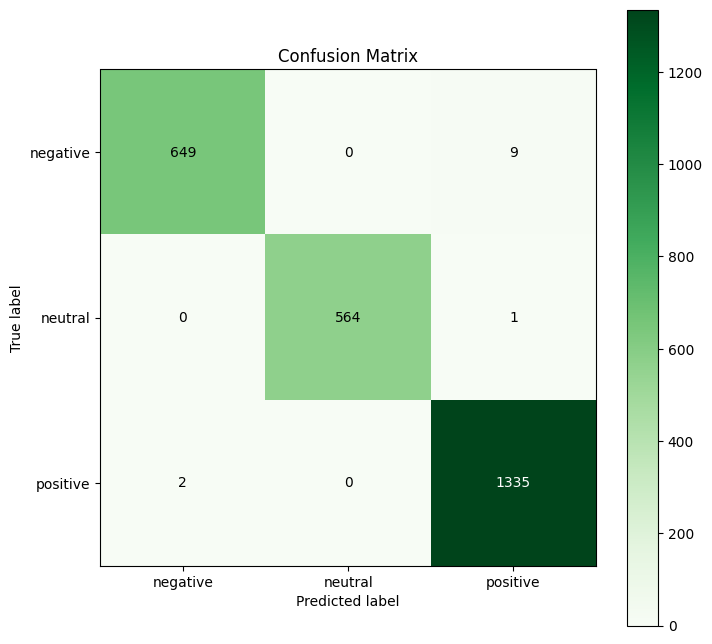

Train accuracy:  0.9953125
Test accuracy:  0.99375
Validation accuracy:  0.9921875


In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
train_model(MultinomialNB(), X_train_tfidf, y_train, X_test_tfidf, y_test, is_neuralnet=False)

Hiện tại vector thu được từ svd có số âm, ta cần scale lại để vector không còn số âm

In [ ]:
X_train_tfidf_ngram_svd[0]

array([ 7.05364401e-02,  9.68318316e-03,  1.90436814e-04,  1.47999635e-02,
        4.48033127e-03,  6.98033914e-04,  2.98822239e-02, -3.08891335e-03,
       -3.38338138e-03, -2.39270017e-03, -2.54911102e-02, -7.08458785e-03,
        5.24355950e-03,  3.57793160e-04, -4.00389869e-03,  1.08450818e-03,
        1.62161724e-02,  9.43188616e-03,  7.28137715e-03,  1.04352980e-02,
       -1.90432635e-03,  2.72757422e-03,  7.27574466e-03,  1.16200531e-02,
        4.29460034e-02, -1.07085092e-02, -2.26711782e-03, -2.29112866e-03,
       -4.60817828e-03, -7.77696546e-03, -9.09875132e-03,  4.14491646e-02,
        3.14523275e-03,  2.18751973e-02,  8.87547817e-15,  2.43285843e-02,
       -1.90297149e-02, -1.77865323e-02,  4.76338065e-03, -2.49213229e-03,
        4.76290630e-03, -7.52122151e-03,  1.11404309e-02, -9.68708134e-03,
        8.82884351e-03, -5.75694998e-03,  1.87189015e-03, -3.01832564e-03,
        1.90618285e-02,  1.25816131e-03,  1.36312445e-03,  4.51429388e-02,
       -1.30696675e-02, -

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_train_tfidf_ngram_svd)
X_train_tfidf_ngram_svd_scaled = scaler.transform(X_train_tfidf_ngram_svd)
X_test_tfidf_ngram_svd_scaled = scaler.transform(X_test_tfidf_ngram_svd)

xuất thử 1 vector để thấy các phần tử đều không âm

In [ ]:
X_train_tfidf_ngram_svd_scaled[0]

array([1.26970743e-01, 4.10350531e-01, 2.79154343e-01, 4.94496618e-01,
       3.98619066e-01, 3.58467407e-01, 2.88015553e-01, 4.62342726e-01,
       3.46704520e-01, 4.48752739e-01, 4.05370646e-01, 2.88902941e-01,
       2.52333892e-01, 2.17407707e-02, 3.45205897e-01, 3.04022413e-01,
       5.12410213e-01, 3.24582816e-01, 4.17617990e-01, 4.67227047e-01,
       7.01038882e-02, 3.84173050e-01, 4.25292851e-01, 4.00145730e-01,
       3.92159110e-01, 3.55894410e-01, 3.53707876e-01, 1.58298254e-01,
       4.90459130e-01, 3.55733588e-01, 8.73366921e-02, 5.29855498e-01,
       2.76582380e-01, 4.95736688e-01, 1.26625385e-13, 3.56445298e-01,
       3.27331369e-01, 3.81274139e-01, 4.43208957e-01, 4.82207555e-01,
       1.88182548e-01, 4.65855103e-01, 4.74939806e-01, 2.35109084e-01,
       4.49700588e-01, 2.90828203e-01, 3.35018485e-01, 4.44371724e-01,
       3.78712729e-01, 3.75050991e-01, 4.17281087e-01, 5.23073036e-01,
       6.27272616e-02, 8.36835023e-02, 3.05047159e-01, 4.06314493e-01,
      

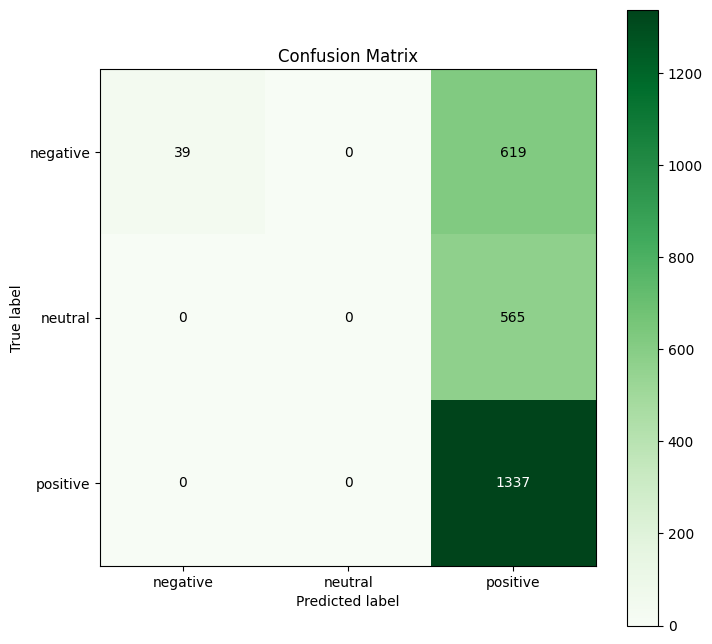

Train accuracy:  0.5375
Test accuracy:  0.54125
Validation accuracy:  0.571875


In [ ]:
train_model(MultinomialNB(), X_train_tfidf_ngram_svd_scaled, y_train, X_test_tfidf_ngram_svd_scaled, y_test, is_neuralnet=False)

##### Linear Classifier

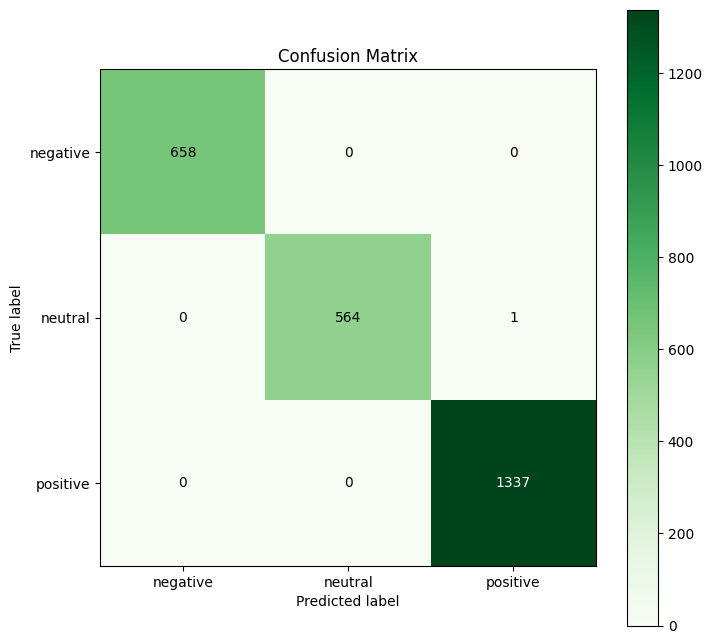

Train accuracy:  0.999609375
Test accuracy:  0.99875
Validation accuracy:  0.9984375


In [ ]:
from sklearn.linear_model import LogisticRegression
train_model(LogisticRegression(), X_train_tfidf, y_train, X_test_tfidf, y_test, is_neuralnet=False)


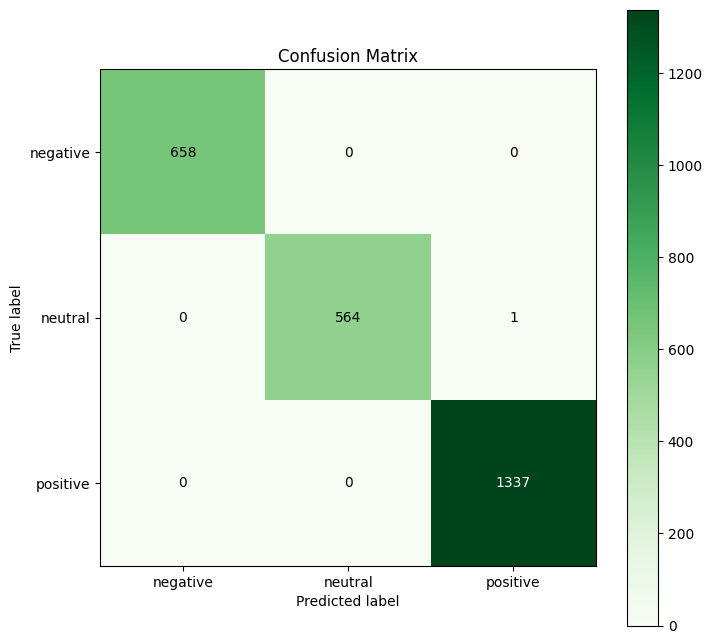

Train accuracy:  0.999609375
Test accuracy:  0.99875
Validation accuracy:  0.9984375


In [ ]:
train_model(LogisticRegression(), X_train_tfidf_svd, y_train, X_test_tfidf_svd, y_test, is_neuralnet=False)


##### Support Vector Machine (SVM)

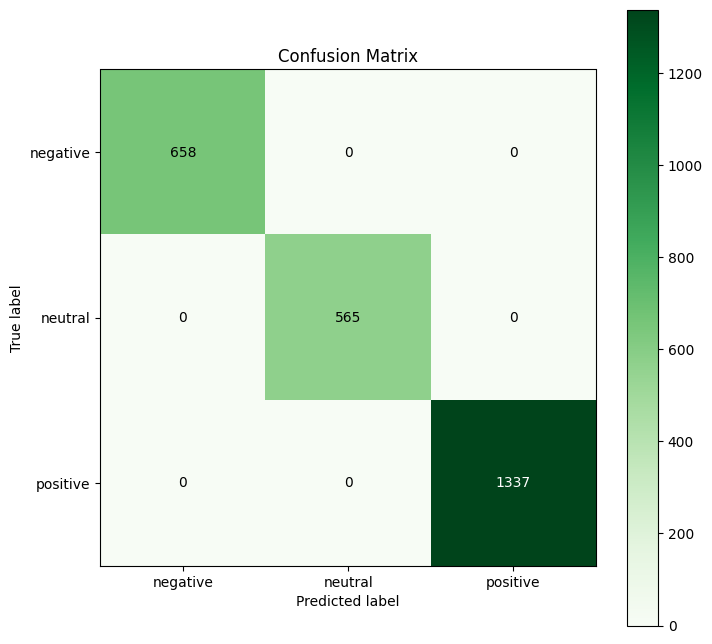

Train accuracy:  1.0
Test accuracy:  0.99875
Validation accuracy:  0.9984375


In [ ]:
from sklearn.svm import SVC
train_model(SVC(), X_train_tfidf_svd, y_train, X_test_tfidf_svd, y_test, is_neuralnet=False)


##### Bagging Model

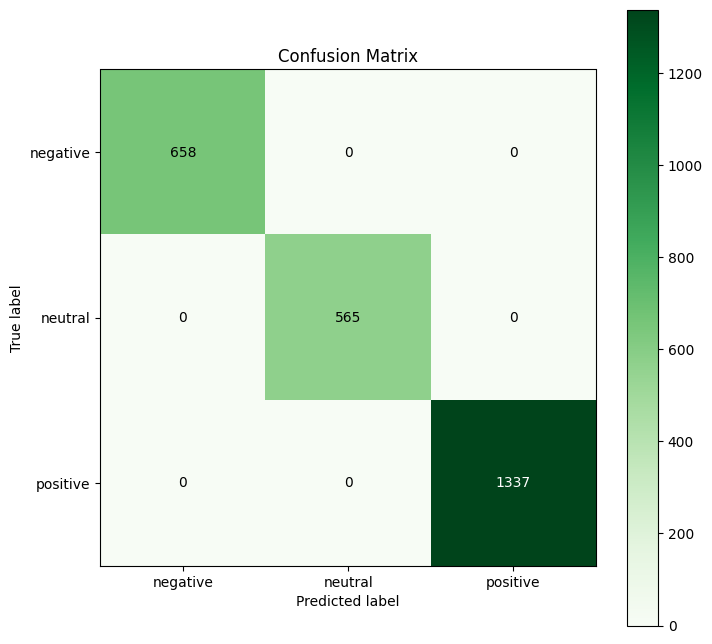

Train accuracy:  1.0
Test accuracy:  0.99875
Validation accuracy:  0.9984375


In [ ]:
from sklearn.ensemble import RandomForestClassifier
train_model(RandomForestClassifier(), X_train_tfidf_svd, y_train, X_test_tfidf_svd, y_test, is_neuralnet=False)
